In [1]:
import pandas as pd
import xgboost as xgb
from sklearn.metrics import f1_score, precision_score
from src.helper import get_split_data

In [2]:
X_trn, y_trn, X_val, y_val, X_tst, y_tst = get_split_data.split_data_for_training(6)

In [3]:
params = {'colsample_bytree': 0.8829682348067726,
          'gamma': 2.153140019195803,
          'learning_rate': 0.2839181641252695,
          'max_depth': 10,
          'n_estimators': 750,
          'reg_alpha': 0.05456053939633371,
          'reg_lambda': 0.014211434927705319,
          'subsample': 0.8413541436147373
          }

xg = xgb.XGBClassifier(**params, random_state=42)
xg.fit(X_trn, y_trn, eval_set=[(X_trn, y_trn), (X_val, y_val)], verbose=False)
y_pred = xg.predict(X_tst)

f1_score(y_tst, y_pred, average='binary').round(3)

ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, The experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:points_diff_segment: object, accel_diff_strength: object

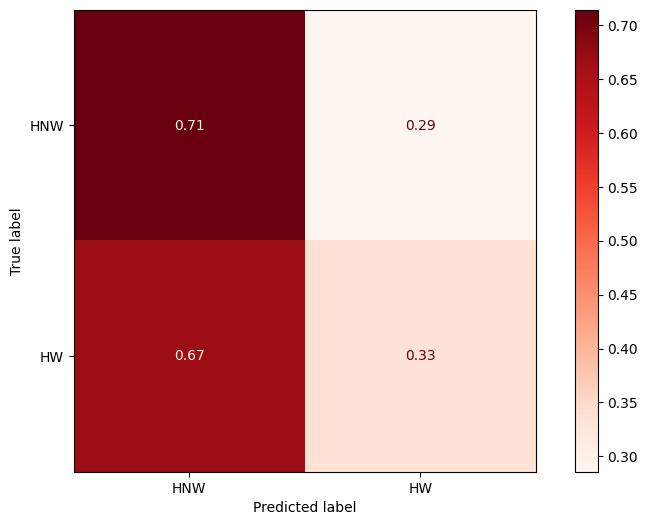

In [5]:
from sklearn import metrics
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))
cm = metrics.confusion_matrix(y_tst, xg.predict(X_tst), normalize='true')
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['HNW', 'HW'])
disp.plot(ax=ax, cmap='Reds')

In [6]:
from sklearn import metrics

cm = metrics.confusion_matrix(y_tst, xg.predict(X_tst))
cm

array([[5, 2],
       [2, 1]])

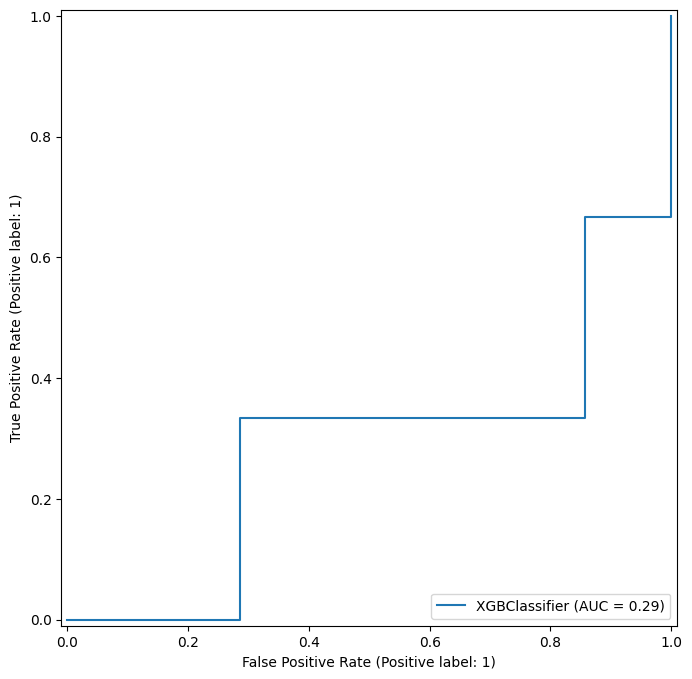

In [8]:
fig, ax = plt.subplots(figsize=(8, 8))
metrics.RocCurveDisplay.from_estimator(xg, X_tst, y_tst, ax=ax)

In [29]:
from src.evaluation.threshold_xgb_classidier import ThresholdXGBClassifier

xgb90 = ThresholdXGBClassifier(xgb=xg, threshold=.5, verbosity=0)
xgb90.fit(X_trn, y_trn, eval_set=[(X_trn, y_trn), (X_val, y_val)], verbose=False)
y_pred = xgb90.predict(X_tst)

precision_score(y_tst, y_pred,)
# f1_score(y_tst, y_pred, average='binary').round(3)

np.float64(0.3333333333333333)

In [23]:
import numpy as np

def get_tpr_fpr(probs, y_truth):
    """
    Calculates true positive rate (TPR) and false positive rate
    (FPR) given predicted probabilities and ground truth labels.

    Parameters:
    probs (np.array): predicted probabilities of positive class
    y_truth (np.array): ground truth labels

    Returns:
    tuple: (tpr, fpr)
    """

    tp = (probs == 1) & (y_truth == 1)
    tn = (probs < 1) & (y_truth == 0)
    fp = (probs == 1) & (y_truth == 0)
    fn = (probs < 1) & (y_truth == 1)
    tpr = tp.sum() / (tp.sum() + fn.sum())
    fpr = fp.sum() / (fp.sum() + tn.sum())
    return tpr, fpr

vals = []
for thresh in np.arange(0, 1, step=.05):
    probs = xgb90.predict_proba(X_tst)[:, 1]
    tpr, fpr = get_tpr_fpr(probs > thresh, y_tst)
    val = [thresh, tpr, fpr]

    for metric in [metrics.accuracy_score, metrics.precision_score,
                   metrics.recall_score, metrics.f1_score,
                   metrics.roc_auc_score]:
        try:
            val.append(metric(y_tst, probs > thresh, zero_division=0))
        except TypeError:
            val.append(metric(y_tst, probs > thresh))

    vals.append(val)

<Axes: title={'center': 'Threshold Metrics'}, xlabel='thresh'>

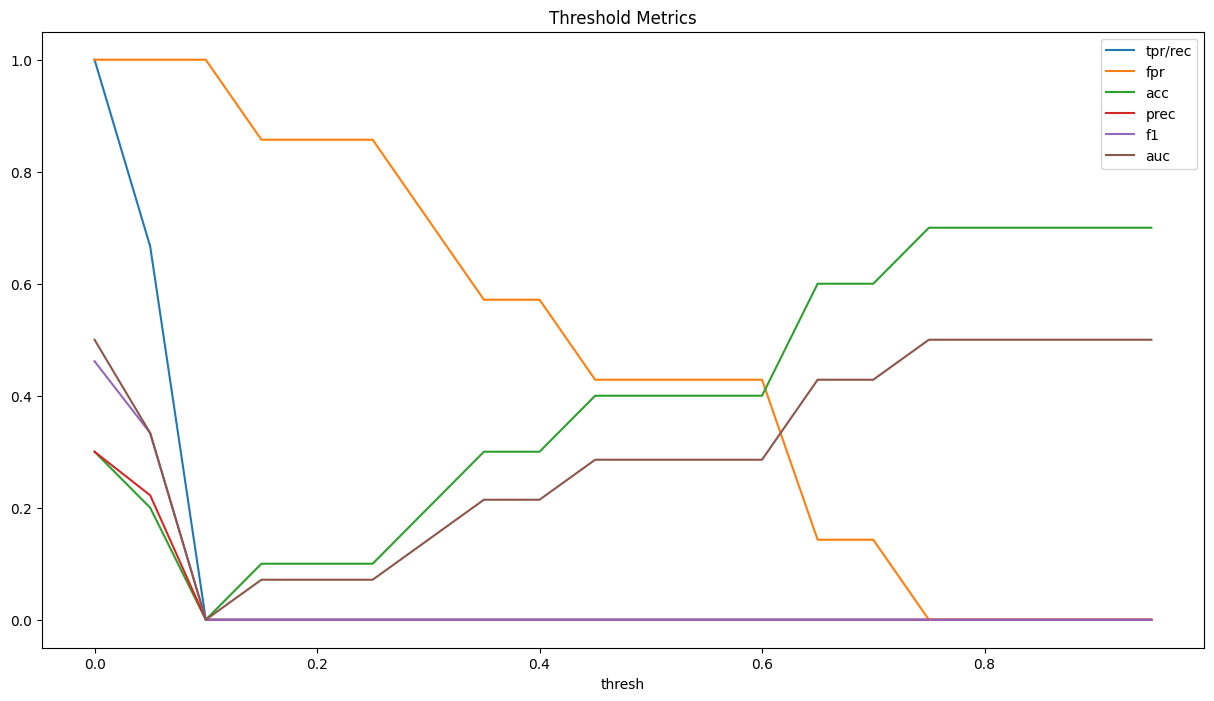

In [24]:
fig, ax = plt.subplots(figsize=(15, 8))
(pd.DataFrame(vals, columns=['thresh', 'tpr/rec', 'fpr', 'acc','prec', 'rec', 'f1', 'auc'])
 .drop(columns='rec')
 .set_index('thresh')
 .plot(ax=ax, title='Threshold Metrics')
 )

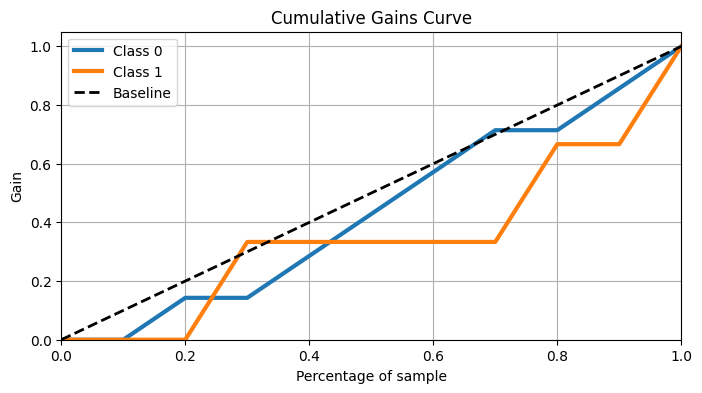

In [26]:
import scikitplot
fig, ax = plt.subplots(figsize=(8, 4))
y_probs = xg.predict_proba(X_tst)
scikitplot.metrics.plot_cumulative_gain(y_tst, y_probs, ax=ax)
ax.set_ylim(0, 1.05)
# ax.annotate('Reach 60% of\nClass 1\nby contacting top 35%', xy=(.35, .6), xytext=(.55,.25), arrowprops={'color':'k'})
ax.legend()